[*********************100%***********************]  3 of 3 completed
Simulating 10-year returns: 100%|██████████| 10/10 [00:00<00:00, 1535.87it/s]


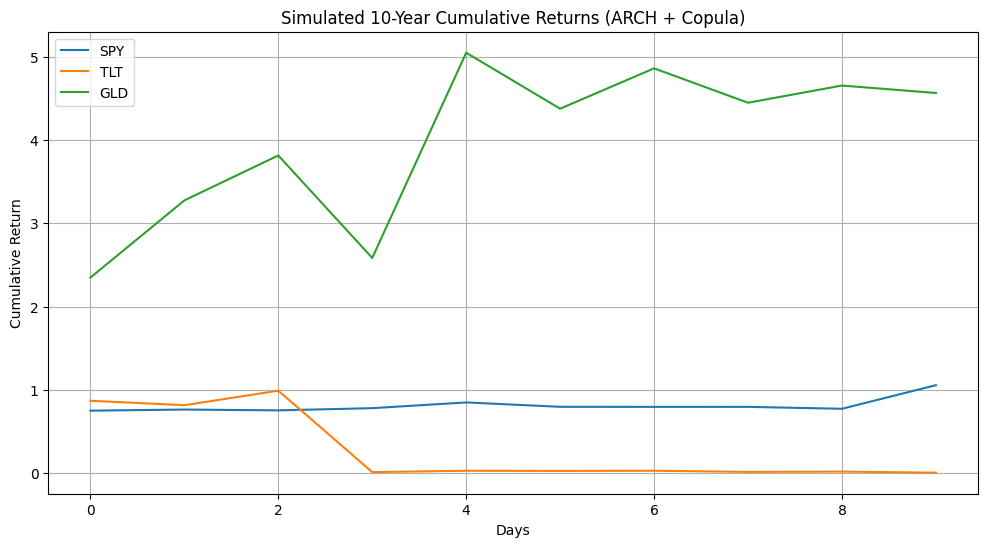

,SPY,TLT,GLD
0,-0.250612,-0.131855,1.348037
1,0.017678,-0.061052,0.395054
2,-0.012786,0.214005,0.164757
3,0.035172,-0.988880,-0.322741
4,0.088296,1.494797,0.954321
5,-0.061952,-0.078456,-0.133164
6,-0.000934,0.092630,0.110725
7,0.000220,-0.511165,-0.084972
8,-0.029138,0.292731,0.046441
9,0.367014,-0.788167,-0.019248


In [21]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import yfinance as yf
from arch import arch_model
from copulae import GaussianCopula

np.random.seed(1234)

end_date = (pd.Timestamp.now()).strftime("%Y-%m-%d")
start_date = (pd.Timestamp.now() - pd.offsets.DateOffset(years=20)).strftime("%Y-%m-%d")
tickers = ["SPY", "TLT", "GLD"]
price_df = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True)[
    "Close"
]

returns = price_df.pct_change().dropna() * 100

standardized_residuals = pd.DataFrame(index=returns.index)
vol_models = {}
for ticker in tickers:
    model = arch_model(returns[ticker], vol="ARCH", p=1)
    res = model.fit(disp="off")
    vol_models[ticker] = res
    standardized_residuals[ticker] = res.std_resid.dropna()

standardized_residuals.dropna(inplace=True)


def ecdf_uniform(x):
    ranks = np.argsort(np.argsort(x))
    return ranks / (len(x) - 1)


u_data = np.column_stack(
    [ecdf_uniform(standardized_residuals[col].values) for col in tickers]
)

copula = GaussianCopula(dim=3)
copula.fit(u_data)


def invert_ecdf(sample, uniform_data):
    sorted_sample = np.sort(sample)
    n = len(sorted_sample)
    return sorted_sample[(uniform_data * n).astype(int).clip(0, n - 1)]


# --- Step 5: Forecast 10 years (≈2520 trading days) using Monte Carlo ---
n_days = 10
n_paths = 1  # for simplicity, one future path

# Get last residuals and variances to start
last_resids = {t: standardized_residuals[t].iloc[-1] for t in tickers}
last_vols = {t: vol_models[t].conditional_volatility.iloc[-1] for t in tickers}
last_params = {t: vol_models[t].params for t in tickers}

simulated_returns = {t: [] for t in tickers}

for day in tqdm(range(n_days), desc="Simulating 10-year returns"):
    # Sample one set of uniform values from copula
    u_sample = copula.random(1)

    # Invert ECDF for residuals
    z_sample = {
        t: invert_ecdf(standardized_residuals[t].values, np.array([u_sample[i]]))[0]
        for i, t in enumerate(tickers)
    }

    for t in tickers:
        alpha1 = last_params[t]["alpha[1]"]
        last_sigma2 = last_vols[t] ** 2
        new_sigma2 = alpha1 * (last_resids[t] ** 2)
        new_sigma = np.sqrt(new_sigma2)
        ret = z_sample[t] * new_sigma

        # Save results
        simulated_returns[t].append(ret)

        # Update for next day
        last_resids[t] = z_sample[t]
        last_vols[t] = new_sigma

# --- Step 6: Convert to cumulative returns ---
sim_df = pd.DataFrame(simulated_returns)
cumulative_returns = (1 + sim_df).cumprod()

# --- Step 7: Plot cumulative returns ---
plt.figure(figsize=(12, 6))
for t in tickers:
    plt.plot(cumulative_returns[t], label=t)
plt.title("Simulated 10-Year Cumulative Returns (ARCH + Copula)")
plt.xlabel("Days")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.show()

# n_sim = 10000
# u_sim = copula.random(n_sim)


# sim_residuals = {}
# for i, ticker in enumerate(tickers):
#     sim_residuals[ticker] = invert_ecdf(
#         standardized_residuals[ticker].values, u_sim[:, i]
#     )

# future_returns = {}
# for ticker in tickers:
#     model = arch_model(returns[ticker], vol="ARCH", p=1)
#     res = model.fit(disp="off")
#     latest_vol = np.sqrt(res.conditional_volatility.iloc[-1])
#     future_returns[ticker] = sim_residuals[ticker] * latest_vol

# pd.DataFrame(future_returns)
sim_df